In [1]:
import os
import time
import numpy as np
import pandas as pd
from datetime import datetime
from sklearn.model_selection import train_test_split

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
from torch.utils import data
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

In [3]:
# Start with 10k rows for testing
df = pd.read_csv('./g-research-crypto-forecasting/train.csv')
df.dropna(axis = 0, inplace = True)
df.head()

,timestamp,Asset_ID,Count,Open,High,Low,Close,Volume,VWAP,Target
0,1514764860,2,40.0,2376.5800,2399.5000,2357.1400,2374.5900,19.233005,2373.116392,-0.004218
1,1514764860,0,5.0,8.5300,8.5300,8.5300,8.5300,78.380000,8.530000,-0.014399
2,1514764860,1,229.0,13835.1940,14013.8000,13666.1100,13850.1760,31.550062,13827.062093,-0.014643
3,1514764860,5,32.0,7.6596,7.6596,7.6567,7.6576,6626.713370,7.657713,-0.013922
4,1514764860,7,5.0,25.9200,25.9200,25.8740,25.8770,121.087310,25.891363,-0.008264


In [4]:
# auxiliary function, from datetime to timestamp
totimestamp = lambda s: np.int32(time.mktime(datetime.strptime(s, "%d/%m/%Y").timetuple()))


In [5]:
btc = df[df["Asset_ID"]==1].set_index("timestamp")
eth = df[df["Asset_ID"]==6].set_index("timestamp")

In [6]:
def log_return(series, periods=1):
    return np.log(series).diff(periods=periods)

In [7]:
upper_shadow = lambda asset: asset.High - np.maximum(asset.Close,asset.Open)
lower_shadow = lambda asset: np.minimum(asset.Close,asset.Open)- asset.Low

X_btc = pd.concat([log_return(btc.VWAP,periods=5), log_return(btc.VWAP,periods=1).abs(), 
               upper_shadow(btc), lower_shadow(btc)], axis=1)
y_btc = btc.Target

X_eth = pd.concat([log_return(eth.VWAP,periods=5), log_return(eth.VWAP,periods=1).abs(), 
               upper_shadow(eth), lower_shadow(eth)], axis=1)
y_eth = eth.Target

In [8]:
X_btc.head(10)

,VWAP,VWAP,0,1
timestamp,,,,
1514764860,NaN,NaN,163.624,169.084
1514764920,NaN,0.000961,217.264,148.102
1514764980,NaN,0.002481,176.500,200.314
1514765040,NaN,0.001629,196.488,191.760
1514765100,NaN,0.003489,189.900,170.474
1514765160,-0.008725,0.002087,282.986,197.112
1514765220,-0.011373,0.001687,280.478,169.930
1514765280,-0.007596,0.001297,193.252,164.256
1514765340,-0.004586,0.001380,228.640,173.422


In [9]:
# select training and test periods
train_window = [totimestamp("01/05/2021"), totimestamp("30/05/2021")]
test_window = [totimestamp("01/06/2021"), totimestamp("30/06/2021")]

X_btc_train = X_btc.loc[train_window[0]:train_window[1]].fillna(0).to_numpy()  # filling NaN's with zeros
y_btc_train = y_btc.loc[train_window[0]:train_window[1]].fillna(0).to_numpy()  

X_btc_test = X_btc.loc[test_window[0]:test_window[1]].fillna(0).to_numpy() 
y_btc_test = y_btc.loc[test_window[0]:test_window[1]].fillna(0).to_numpy() 

X_eth_train = X_eth.loc[train_window[0]:train_window[1]].fillna(0).to_numpy()  
y_eth_train = y_eth.loc[train_window[0]:train_window[1]].fillna(0).to_numpy()  

X_eth_test = X_eth.loc[test_window[0]:test_window[1]].fillna(0).to_numpy() 
y_eth_test = y_eth.loc[test_window[0]:test_window[1]].fillna(0).to_numpy() 

In [10]:
len(X_btc_train)

41760

In [11]:
def create_xy_pairs(X_series, y_series, seq_length):
    data_length = len(X_btc_train)
    pairs = []
    for idx in range(data_length - seq_length):
        x = X_series[idx:idx + seq_length]
        y = y_series[idx + seq_length:idx + seq_length + 1]
        pairs.append((x, y))
    return pairs

In [12]:
SEQ_LENGTH    = 20
btc_train = create_xy_pairs(X_btc_train, y_btc_train, SEQ_LENGTH)
btc_test = create_xy_pairs(X_btc_test, y_btc_test, SEQ_LENGTH)

In [13]:
BATCH_SIZE = 5
btc_train_dl = DataLoader(btc_train, batch_size = BATCH_SIZE, shuffle = False)
btc_test_dl = DataLoader(btc_test, batch_size = 1, shuffle = False)

# RNN

In [14]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")

In [20]:
EPOCHS        = 100
DROPOUT       = 0.2
NUM_LAYERS    = 2
INPUT_DIM     = 4
OUTPUT_SIZE   = 1
HIDDEN_SIZE   = 100
LEARNING_RATE = 0.00001
STATE_DIM     = NUM_LAYERS, BATCH_SIZE, HIDDEN_SIZE

for idx, (x_batch, y_batch) in enumerate(btc_train_dl):
    print(x_batch)
    break

In [21]:
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size, dropout_prob):
        super(RNN, self).__init__()
        
        self.num_layers = num_layers
        self.hidden_size = hidden_size
        
        self.rnn = nn.RNN(input_size, hidden_size, num_layers, batch_first=True, dropout=dropout_prob)
        self.linear = nn.Linear(hidden_size, output_size)
        

    def forward(self, x):
        
        # Initialize hidden state with zeros
        h0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size))
        
        x, (h) = self.rnn(x, h0)
        out = self.linear(x)
        return out

In [22]:
model = RNN(
    INPUT_DIM,
    HIDDEN_SIZE,
    NUM_LAYERS,
    OUTPUT_SIZE,
    DROPOUT
).to(device)

criterion = nn.MSELoss()
optimizer = optim.AdamW(model.linear.parameters(), lr=LEARNING_RATE, weight_decay=0.01)

In [23]:
def training(model, epochs, validate_every=2):

    training_losses = []
    validation_losses = []
    min_validation_loss = np.Inf

    # Set to train mode
    model.train()

    for epoch in tqdm(range(epochs)):

        # Initialize hidden and cell states with dimension:
        # (num_layers * num_directions, batch, hidden_size)
        running_training_loss = 0.0

        # Begin training
        for idx, (x_batch, y_batch) in enumerate(btc_train_dl):
            # Convert to Tensors
            x_batch = x_batch.float().to(device)
            y_batch = y_batch.float().to(device)
      
            optimizer.zero_grad()

            # Make prediction
            output = model(x_batch)

            # Calculate loss
            loss = criterion(output[:, -1, :], y_batch)
            loss.backward()
            running_training_loss += loss.item()

            torch.nn.utils.clip_grad_norm_(model.parameters(), 0.5)
            optimizer.step()
        
        # Average loss across timesteps
        training_losses.append(running_training_loss / len(btc_train_dl))
        
        if epoch % validate_every == 0:
            # Set to eval mode
            model.eval()
            torch.no_grad()
            running_validation_loss = 0.0

            for idx, (x_batch, y_batch) in enumerate(btc_test_dl):

                # Convert to Tensors
                x_batch = x_batch.float().to(device)
                y_batch = y_batch.float().to(device)
      
                output = model(x_batch)
                validation_loss = criterion(output[:, -1, :], y_batch)
                running_validation_loss += validation_loss.item()
        
        validation_losses.append(running_validation_loss / len(btc_test_dl))
        # Reset to training mode
        model.train()
        
    # Visualize loss
    epoch_count = range(1, len(training_losses) + 1)
    plt.plot(epoch_count, training_losses, 'r--')
    plt.legend(['Training Loss'])
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.show()

    val_epoch_count = range(1, len(validation_losses) + 1)
    plt.plot(val_epoch_count, validation_losses, 'b--')
    plt.legend(['Validation loss'])
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.show()

100%|██████████| 30/30 [19:57<00:00, 39.90s/it]


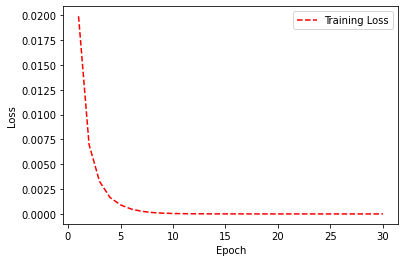

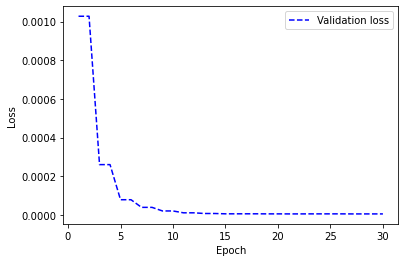

In [24]:
training(model, 30)

epoch = 30
save_model = True
if save_model:
    state = {
        'net': model.state_dict(),
        'epoch': epoch,
    }
    os.makedirs('RNN', exist_ok=True)
    torch.save(state, './RNN/btc_norm_rnn_e30.ckpt')

In [85]:
model = RNN(
    INPUT_DIM,
    HIDDEN_SIZE,
    NUM_LAYERS,
    OUTPUT_SIZE,
    DROPOUT
).to(device)
load_model = True
if load_model:
    checkpoint = torch.load('./RNN/btc_rnn_e50.ckpt')
    model.load_state_dict(checkpoint['net'])
    start_epoch = checkpoint['epoch']

In [25]:
pred = []
for idx, (x_batch, y_batch) in tqdm(enumerate(btc_test_dl)):
    # Convert to Tensors
    x_batch = x_batch.float().to(device)
    y_batch = y_batch.float().to(device)
      
    output = model(x_batch)[:, -1, :].item()
    pred.append(output)

41740it [00:34, 1226.10it/s]


In [26]:
pred_btc = np.array(pred)
test_btc = y_btc_test[20:]

In [28]:
np.corrcoef(pred_btc, test_btc)[0,1]

0.0008828156215216786

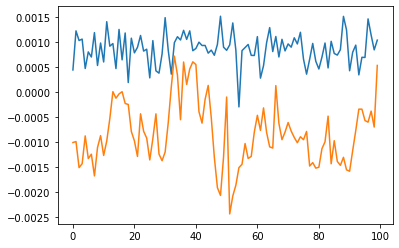

In [27]:
plt.plot(pred_btc[100:200])
plt.plot(test_btc[100:200])

# LSTM

In [23]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")

In [25]:
EPOCHS        = 100
DROPOUT       = 0.2
NUM_LAYERS    = 2
INPUT_DIM     = 4
OUTPUT_SIZE   = 1
HIDDEN_SIZE   = 100
LEARNING_RATE = 0.0001
STATE_DIM     = NUM_LAYERS, BATCH_SIZE, HIDDEN_SIZE

In [31]:
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size, dropout_prob):
        super(LSTM, self).__init__()

        self.num_layers = num_layers
        self.hidden_size = hidden_size

        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, dropout=dropout_prob)
        self.linear = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        
        # Initialize hidden state with zeros
        states = (Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size)),
                  Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size)))
        
        x, (h, c) = self.lstm(x, states)
        out = self.linear(x)
        return out

In [32]:
model = LSTM(
    INPUT_DIM,
    HIDDEN_SIZE,
    NUM_LAYERS,
    OUTPUT_SIZE,
    DROPOUT
).to(device)

criterion = nn.MSELoss()
optimizer = optim.AdamW(model.linear.parameters(), lr=LEARNING_RATE, weight_decay=0.01)

In [33]:
def training(model, epochs, validate_every=2):

    training_losses = []
    validation_losses = []
    min_validation_loss = np.Inf

    # Set to train mode
    model.train()

    for epoch in tqdm(range(epochs)):

        # Initialize hidden and cell states with dimension:
        # (num_layers * num_directions, batch, hidden_size)
        running_training_loss = 0.0

        # Begin training
        for idx, (x_batch, y_batch) in enumerate(btc_train_dl):
            # Convert to Tensors
            x_batch = x_batch.float().to(device)
            y_batch = y_batch.float().to(device)
      
            optimizer.zero_grad()

            # Make prediction
            output = model(x_batch)

            # Calculate loss
            loss = criterion(output[:, -1, :], y_batch)
            loss.backward()
            running_training_loss += loss.item()

            torch.nn.utils.clip_grad_norm_(model.parameters(), 0.5)
            optimizer.step()
        
        # Average loss across timesteps
        training_losses.append(running_training_loss / len(btc_train_dl))
        
        if epoch % validate_every == 0:
            # Set to eval mode
            model.eval()
            torch.no_grad()
            running_validation_loss = 0.0

            for idx, (x_batch, y_batch) in enumerate(btc_test_dl):

                # Convert to Tensors
                x_batch = x_batch.float().to(device)
                y_batch = y_batch.float().to(device)
      
                output = model(x_batch)
                validation_loss = criterion(output[:, -1, :], y_batch)
                running_validation_loss += validation_loss.item()
        
        validation_losses.append(running_validation_loss / len(btc_test_dl))
        # Reset to training mode
        model.train()
        
    # Visualize loss
    epoch_count = range(1, len(training_losses) + 1)
    plt.plot(epoch_count, training_losses, 'r--')
    plt.legend(['Training Loss'])
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.show()

    val_epoch_count = range(1, len(validation_losses) + 1)
    plt.plot(val_epoch_count, validation_losses, 'b--')
    plt.legend(['Validation loss'])
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.show()

In [34]:
training(model, 10)

100%|██████████| 50/50 [1:02:17<00:00, 74.74s/it]


epoch = 50
save_model = True
if save_model:
    state = {
        'net': model.state_dict(),
        'epoch': epoch,
    }
    os.makedirs('LSTM', exist_ok=True)
    torch.save(state, './LSTM/btc_lstm_e50.ckpt')

In [59]:
pred = []
for idx, (x_batch, y_batch) in tqdm(enumerate(btc_test_dl)):
    # Convert to Tensors
    x_batch = x_batch.float().to(device)
    y_batch = y_batch.float().to(device)
      
    output = model(x_batch)[:, -1, :].item()
    pred.append(output)

41740it [01:16, 543.36it/s]


In [73]:
pred_btc = np.array(pred)

In [76]:
len(pred_btc)

41740

In [75]:
test_btc = y_btc_test[20:]

In [77]:
len(test_btc)

41740

In [78]:
np.corrcoef(pred_btc, test_btc)[0,1]

0.003526890610312263

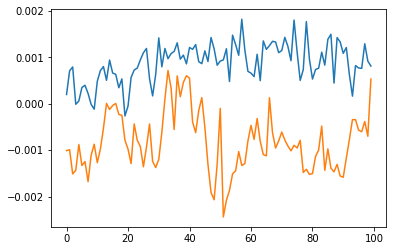

In [84]:
plt.plot(pred_btc[100:200])
plt.plot(test_btc[100:200])

# GRU

In [101]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")

In [102]:
EPOCHS        = 100
DROPOUT       = 0.2
NUM_LAYERS    = 2
INPUT_DIM     = 4
OUTPUT_SIZE   = 1
HIDDEN_SIZE   = 100
LEARNING_RATE = 0.0001
STATE_DIM     = NUM_LAYERS, BATCH_SIZE, HIDDEN_SIZE

In [103]:
class GRU(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size, dropout_prob):
        super(GRU, self).__init__()
        
        self.num_layers = num_layers
        self.hidden_size = hidden_size
        
        self.rnn = nn.GRU(input_size, hidden_size, num_layers, batch_first=True, dropout=dropout_prob)
        self.linear = nn.Linear(hidden_size, output_size)
        

    def forward(self, x):
        
        # Initialize hidden state with zeros
        h0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size))
        
        x, (h) = self.rnn(x, h0)
        out = self.linear(x)
        return out

In [104]:
model = GRU(
    INPUT_DIM,
    HIDDEN_SIZE,
    NUM_LAYERS,
    OUTPUT_SIZE,
    DROPOUT
).to(device)

criterion = nn.MSELoss()
optimizer = optim.AdamW(model.linear.parameters(), lr=LEARNING_RATE, weight_decay=0.01)

In [105]:
def training(model, epochs, validate_every=2):

    training_losses = []
    validation_losses = []
    min_validation_loss = np.Inf

    # Set to train mode
    model.train()

    for epoch in tqdm(range(epochs)):

        # Initialize hidden and cell states with dimension:
        # (num_layers * num_directions, batch, hidden_size)
        running_training_loss = 0.0

        # Begin training
        for idx, (x_batch, y_batch) in enumerate(btc_train_dl):
            # Convert to Tensors
            x_batch = x_batch.float().to(device)
            y_batch = y_batch.float().to(device)
      
            optimizer.zero_grad()

            # Make prediction
            output = model(x_batch)

            # Calculate loss
            loss = criterion(output[:, -1, :], y_batch)
            loss.backward()
            running_training_loss += loss.item()

            torch.nn.utils.clip_grad_norm_(model.parameters(), 0.5)
            optimizer.step()
        
        # Average loss across timesteps
        training_losses.append(running_training_loss / len(btc_train_dl))
        
        if epoch % validate_every == 0:
            # Set to eval mode
            model.eval()
            torch.no_grad()
            running_validation_loss = 0.0

            for idx, (x_batch, y_batch) in enumerate(btc_test_dl):

                # Convert to Tensors
                x_batch = x_batch.float().to(device)
                y_batch = y_batch.float().to(device)
      
                output = model(x_batch)
                validation_loss = criterion(output[:, -1, :], y_batch)
                running_validation_loss += validation_loss.item()
        
        validation_losses.append(running_validation_loss / len(btc_test_dl))
        # Reset to training mode
        model.train()
        
    # Visualize loss
    epoch_count = range(1, len(training_losses) + 1)
    plt.plot(epoch_count, training_losses, 'r--')
    plt.legend(['Training Loss'])
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.show()

    val_epoch_count = range(1, len(validation_losses) + 1)
    plt.plot(val_epoch_count, validation_losses, 'b--')
    plt.legend(['Validation loss'])
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.show()

100%|██████████| 50/50 [55:54<00:00, 67.08s/it] 


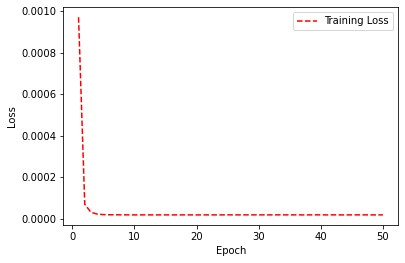

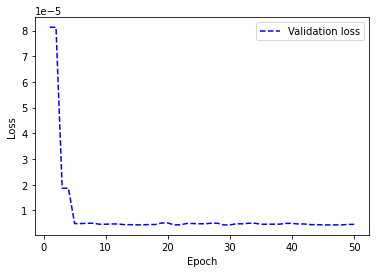

In [106]:
training(model, 50)

In [107]:
epoch = 50
save_model = True
if save_model:
    state = {
        'net': model.state_dict(),
        'epoch': epoch,
    }
    os.makedirs('GRU', exist_ok=True)
    torch.save(state, './GRU/btc_gru_e50.ckpt')

In [110]:
pred = []
for idx, (x_batch, y_batch) in tqdm(enumerate(btc_test_dl)):
    # Convert to Tensors
    x_batch = x_batch.float().to(device)
    y_batch = y_batch.float().to(device)
      
    output = model(x_batch)[:, -1, :].item()
    pred.append(output)

41740it [01:26, 485.01it/s]


In [111]:
pred_btc = np.array(pred)
test_btc = y_btc_test[20:]

In [112]:
np.corrcoef(pred_btc, test_btc)[0,1]

-0.006154054581286141

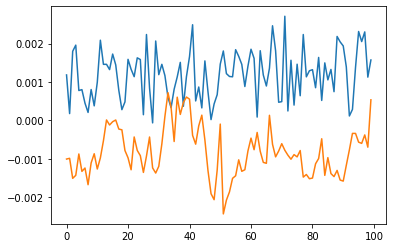

In [113]:
plt.plot(pred_btc[100:200])
plt.plot(test_btc[100:200])